<a href="https://colab.research.google.com/github/Trader-Markets/Video_Games_Sales/blob/main/Video_Game_Sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Video Game Sales Analysis & Prediction

In [2]:
# pip install --upgrade scikit-learn

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
import lightgbm as lgb

np.random.seed(42)


In [4]:
# Load data into a pandas DataFrame
df = pd.read_csv("Video_Games_Sales.csv")
df["Global_Sales"] = df["Global_Sales"].apply(lambda x:x*1000000)

#Drop the individual sales columns
df = df.drop(columns=["NA_Sales","EU_Sales","JP_Sales","Other_Sales"])
df['User_Score'] = pd.to_numeric(df['User_Score'], errors='coerce')

print("Data shape:", df.shape)
df.head()



Data shape: (16719, 12)


,Name,Platform,Year_of_Release,Genre,Publisher,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,82530000.0,76.0,51.0,8.0,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,40240000.0,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,35520000.0,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,32770000.0,80.0,73.0,8.0,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,31370000.0,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Basic EDA: Inspect dataset summary and missing values
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16719 entries, 0 to 16718
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16717 non-null  object 
 1   Platform         16719 non-null  object 
 2   Year_of_Release  16450 non-null  float64
 3   Genre            16717 non-null  object 
 4   Publisher        16665 non-null  object 
 5   Global_Sales     16719 non-null  float64
 6   Critic_Score     8137 non-null   float64
 7   Critic_Count     8137 non-null   float64
 8   User_Score       7590 non-null   float64
 9   User_Count       7590 non-null   float64
 10  Developer        10096 non-null  object 
 11  Rating           9950 non-null   object 
dtypes: float64(6), object(6)
memory usage: 1.5+ MB
None
       Year_of_Release  Global_Sales  Critic_Score  Critic_Count   User_Score  \
count     16450.000000  1.671900e+04   8137.000000   8137.000000  7590.000000   
mean       2006.487356  5.33

In [6]:
#Drop rows which have both Critic_Score and Critic_Count are null and same for User_Score and User_Count
df = df[~(
    (df['Critic_Score'].isnull() & (df['Critic_Count'] == '')) |
    (df['User_Score'].isnull() & (df['User_Count'] == ''))
)]



In [7]:
df = df.reset_index(drop=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16719 entries, 0 to 16718
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16717 non-null  object 
 1   Platform         16719 non-null  object 
 2   Year_of_Release  16450 non-null  float64
 3   Genre            16717 non-null  object 
 4   Publisher        16665 non-null  object 
 5   Global_Sales     16719 non-null  float64
 6   Critic_Score     8137 non-null   float64
 7   Critic_Count     8137 non-null   float64
 8   User_Score       7590 non-null   float64
 9   User_Count       7590 non-null   float64
 10  Developer        10096 non-null  object 
 11  Rating           9950 non-null   object 
dtypes: float64(6), object(6)
memory usage: 1.5+ MB


In [8]:
missing = df.isnull().sum()
missing_percent = (missing / len(df)) * 100
missing_df = pd.DataFrame({'Missing Values': missing, 'Percentage': missing_percent}).sort_values(by='Percentage', ascending=False)
missing_df.head(10)


,Missing Values,Percentage
User_Score,9129,54.602548
User_Count,9129,54.602548
Critic_Score,8582,51.330821
Critic_Count,8582,51.330821
Rating,6769,40.486871
Developer,6623,39.613613
Year_of_Release,269,1.608948
Publisher,54,0.322986
Name,2,0.011962
Genre,2,0.011962


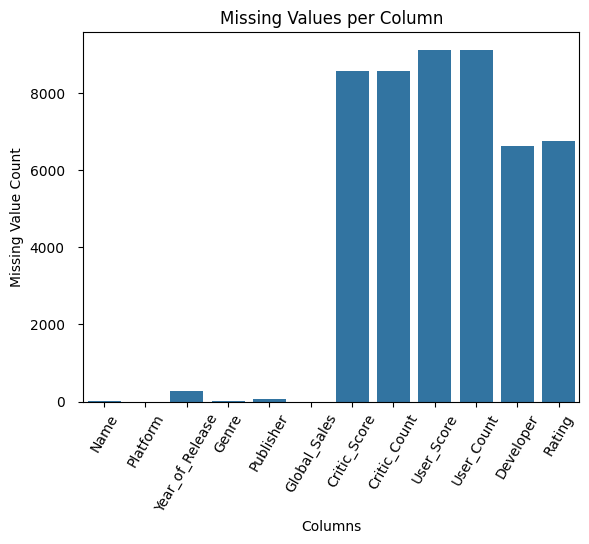

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate missing values for each column
missing_counts = df.isnull().sum()

# Create a bar plot where:
# x-axis: column names
# y-axis: count of missing values in each column
ax = sns.barplot(x=missing_counts.index, y=missing_counts.values)

# Increase padding between y-axis labels and the axis
ax.tick_params(axis='y', which='major', pad=10)  # Adjust pad as needed

plt.xticks(rotation=60)
plt.title('Missing Values per Column')
plt.xlabel('Columns')
plt.ylabel('Missing Value Count')
plt.show()


In [10]:
# plt.figure(figsize=(12,6))
# sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
# plt.title('Heatmap of Missing Values')
# plt.show()


In [11]:
# Drop columns with more than 60% missing values
threshold = 0.4 * len(df)
df = df.dropna(axis=1, thresh=threshold)

print("Data shape after dropping columns:", df.shape)


Data shape after dropping columns: (16719, 12)


In [12]:
#Impute non-null missing values(tbd in User Score) to null
df.replace(["tbd"],np.nan,inplace=True)
df.head()


,Name,Platform,Year_of_Release,Genre,Publisher,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,82530000.0,76.0,51.0,8.0,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,40240000.0,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,35520000.0,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,32770000.0,80.0,73.0,8.0,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,31370000.0,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
#Filling null ratings as RP (Rating Pending) value

df['Rating'].fillna('RP', inplace=True)  # Assign 'RP' or 'Unrated'

#Replacing K-A with E as they are both the same rating level
df.replace(["K-A"],"E",inplace=True)


<ipython-input-13-632812a3813e>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Rating'].fillna('RP', inplace=True)  # Assign 'RP' or 'Unrated'


In [14]:

df["Rating"].isin(["K-A"]).any()

np.False_

In [15]:
# Impute missing values
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
cat_cols = df.select_dtypes(include=['object']).columns

df[num_cols] = SimpleImputer(strategy='median').fit_transform(df[num_cols])
df[cat_cols] = SimpleImputer(strategy='most_frequent').fit_transform(df[cat_cols])
print("Total missing values after imputation:", df.isnull().sum().sum())

Total missing values after imputation: 0


In [16]:
#Checking if any values are 0 in the column
(df["Critic_Count"] == 0).any()

np.False_

In [17]:
#Combine columns into 1 column to have better analysis.

df['User_Rating'] = np.where(df['User_Count'] != 0, df['User_Score'] / df['User_Count'], np.nan)
df['Critic_Rating'] = np.where(df['Critic_Count'] != 0, df['Critic_Score'] / df['Critic_Count'], np.nan)


In [18]:
df = df.drop(['Critic_Score', 'Critic_Count', 'User_Score', 'User_Count'], axis=1)

In [19]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16719 entries, 0 to 16718
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16719 non-null  object 
 1   Platform         16719 non-null  object 
 2   Year_of_Release  16719 non-null  float64
 3   Genre            16719 non-null  object 
 4   Publisher        16719 non-null  object 
 5   Global_Sales     16719 non-null  float64
 6   Developer        16719 non-null  object 
 7   Rating           16719 non-null  object 
 8   User_Rating      16719 non-null  float64
 9   Critic_Rating    16719 non-null  float64
dtypes: float64(4), object(6)
memory usage: 1.3+ MB


,Name,Platform,Year_of_Release,Genre,Publisher,Global_Sales,Developer,Rating,User_Rating,Critic_Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,82530000.0,Nintendo,E,0.024845,1.490196
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,40240000.0,Ubisoft,RP,0.312500,3.380952
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,35520000.0,Nintendo,E,0.011707,1.123288
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,32770000.0,Nintendo,E,0.041667,1.095890
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,31370000.0,Ubisoft,RP,0.312500,3.380952


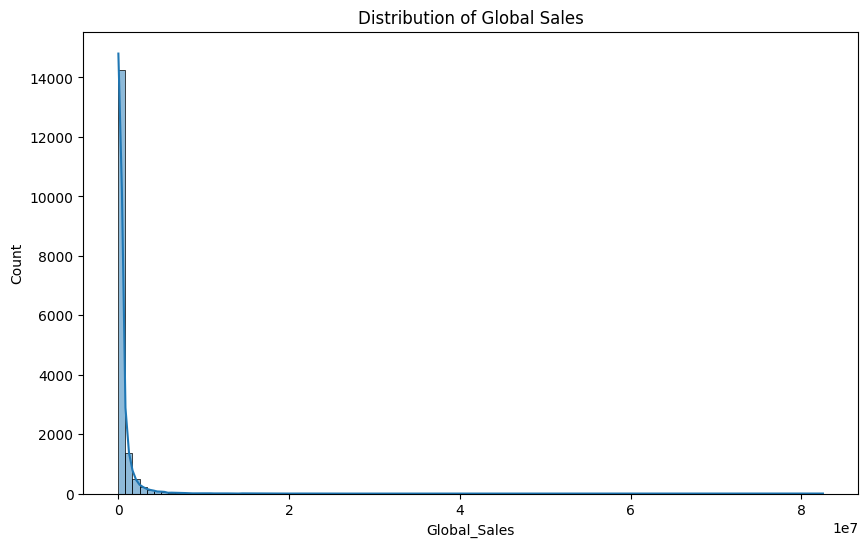

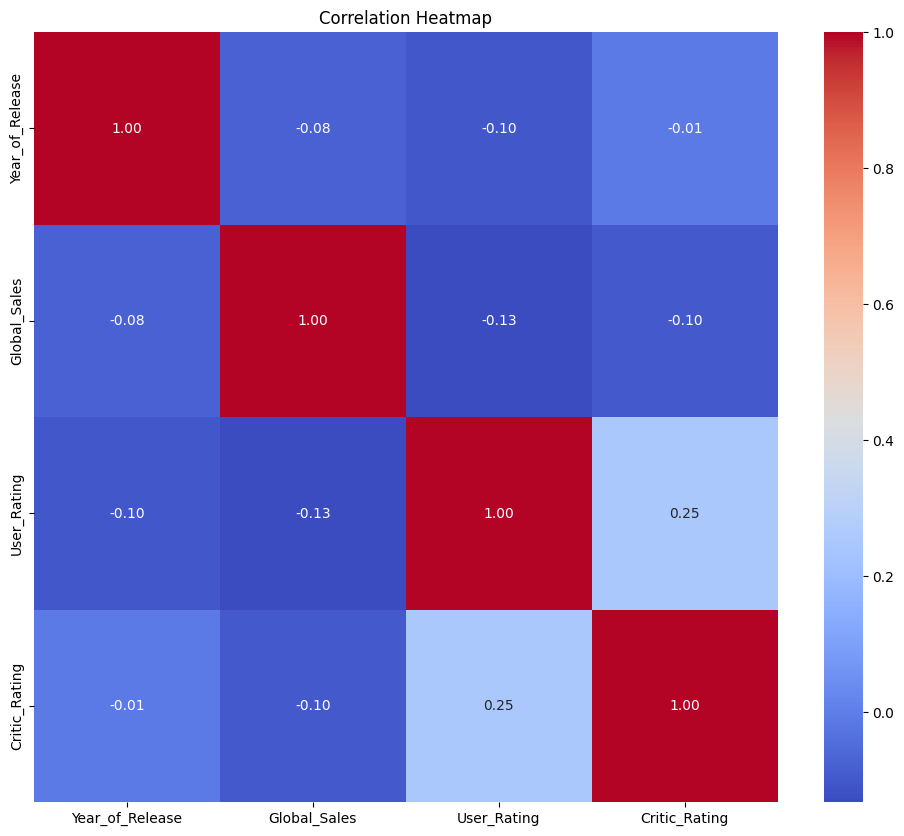

In [21]:
# Additional EDA: Distribution of Global Sales and correlation heatmap


plt.figure(figsize=(10,6))
sns.histplot(df['Global_Sales'], bins=100, kde=True)
plt.title('Distribution of Global Sales')
plt.show()

# Select numeric columns only
numeric_df = df.select_dtypes(include=['int64', 'float64'])

plt.figure(figsize=(12,10))
sns.heatmap(numeric_df.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


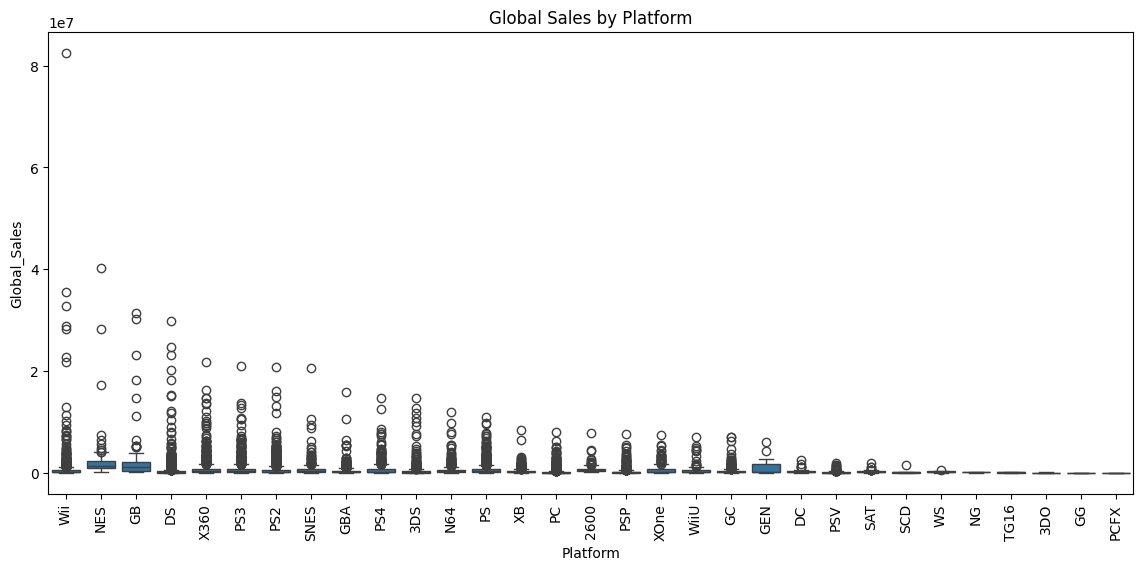

In [22]:
# Boxplot of Global Sales by Platform
plt.figure(figsize=(14,6))
sns.boxplot(data=df, x='Platform', y='Global_Sales')
plt.xticks(rotation=90)
plt.title('Global Sales by Platform')
plt.show()

In [23]:
# Define target variable and features
X = df.drop('Global_Sales', axis=1)
y = df['Global_Sales']

In [24]:
# Split the data into training and test sets using an 80:20 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Training set shape: (13375, 9)
Test set shape: (3344, 9)


In [25]:
# Define preprocessing pipeline for numerical and categorical features
# Assume: Numerical features - 'Year_of_Release', 'Critic_Score', 'Critic_Count', 'User_Score', 'User_Count'
#Categorical features - 'Name','Platform', 'Genre', 'Publisher','Developer','Rating'
#Ordinal Categorical features - Rating
from sklearn.preprocessing import OrdinalEncoder

num_features = ['Year_of_Release','User_Rating','Critic_Rating']
cat_features = ['Name','Platform', 'Genre', 'Publisher','Developer']
ordinal_cat_features = ["Rating"]
rating_order = ['EC', 'E', 'E10+', 'T', 'M', 'AO', 'RP']


preprocessor = ColumnTransformer(transformers=[
    ('num_scaler', StandardScaler(), num_features),
    ('cat_encoder', OneHotEncoder(handle_unknown='ignore'), cat_features),
    ('ordinal_encoder', OrdinalEncoder(categories=[rating_order]), ordinal_cat_features)
])

In [26]:
# Define models and their hyperparameter grids
models = {
    "LinearRegression": LinearRegression(),
    "DecisionTree": DecisionTreeRegressor(random_state=42),
    "RandomForest": RandomForestRegressor(random_state=42),
    "XGBoost": xgb.XGBRegressor(random_state=42),
    "LightGBM": lgb.LGBMRegressor(random_state=42)
}

param_grids = {
    "LinearRegression": {},
    "DecisionTree": {'model__max_depth': [5, 10, None]},
    "RandomForest": {'model__n_estimators': [100, 150], 'model__max_depth': [5, 10]},
    "XGBoost": {'model__n_estimators': [100, 150], 'model__max_depth': [3, 6]},
    "LightGBM": {'model__n_estimators': [100, 150], 'model__max_depth': [3, 6]}
}

In [27]:
# Grid search for RandomForest
pipe_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('model', models['RandomForest'])
])
param_grid_rf = param_grids["RandomForest"]
grid_rf = GridSearchCV(pipe_rf, param_grid_rf, cv=5, scoring='r2', n_jobs=-1)
grid_rf.fit(X_train, y_train)
print("RandomForest Best Params:", grid_rf.best_params_)
print("RandomForest Best Score:", grid_rf.best_score_)

RandomForest Best Params: {'model__max_depth': 10, 'model__n_estimators': 100}
RandomForest Best Score: 0.2975665181143065


In [28]:
# Grid search for DecisionTree
pipe_dt = Pipeline([
    ('preprocessor', preprocessor),
    ('model', models['DecisionTree'])
])
param_grid_dt = param_grids["DecisionTree"]
grid_dt = GridSearchCV(pipe_dt, param_grid_dt, cv=5, scoring='r2', n_jobs=-1)
grid_dt.fit(X_train, y_train)
print("DecisionTree Best Params:", grid_dt.best_params_)
print("DecisionTree Best Score:", grid_dt.best_score_)

DecisionTree Best Params: {'model__max_depth': 10}
DecisionTree Best Score: 0.23886302488764324


In [29]:
# Grid search for XGBoost
pipe_xgb = Pipeline([
    ('preprocessor', preprocessor),
    ('model', models['XGBoost'])
])
param_grid_xgb = param_grids["XGBoost"]
grid_xgb = GridSearchCV(pipe_xgb, param_grid_xgb, cv=5, scoring='r2', n_jobs=-1)
grid_xgb.fit(X_train, y_train)
print("XGBoost Best Params:", grid_xgb.best_params_)
print("XGBoost Best Score:", grid_xgb.best_score_)

XGBoost Best Params: {'model__max_depth': 6, 'model__n_estimators': 150}
XGBoost Best Score: 0.3696860450907983


In [30]:
# Grid search for LightGBM
pipe_lgb = Pipeline([
    ('preprocessor', preprocessor),
    ('model', models['LightGBM'])
])
param_grid_lgb = param_grids["LightGBM"]
grid_lgb = GridSearchCV(pipe_lgb, param_grid_lgb, cv=5, scoring='r2', n_jobs=-1)
grid_lgb.fit(X_train, y_train)
print("LightGBM Best Params:", grid_lgb.best_params_)
print("LightGBM Best Score:", grid_lgb.best_score_)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001231 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 920
[LightGBM] [Info] Number of data points in the train set: 13375, number of used features: 186
[LightGBM] [Info] Start training from score 525554.392523
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [36]:
df.head(10)

,Name,Platform,Year_of_Release,Genre,Publisher,Global_Sales,Developer,Rating,User_Rating,Critic_Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,82530000.0,Nintendo,E,0.024845,1.490196
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,40240000.0,Ubisoft,RP,0.312500,3.380952
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,35520000.0,Nintendo,E,0.011707,1.123288
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,32770000.0,Nintendo,E,0.041667,1.095890
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,31370000.0,Ubisoft,RP,0.312500,3.380952
5,Tetris,GB,1989.0,Puzzle,Nintendo,30260000.0,Ubisoft,RP,0.312500,3.380952
6,New Super Mario Bros.,DS,2006.0,Platform,Nintendo,29800000.0,Nintendo,E,0.019722,1.369231
7,Wii Play,Wii,2006.0,Misc,Nintendo,28920000.0,Nintendo,E,0.051163,1.414634
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,Nintendo,28320000.0,Nintendo,E,0.014141,1.087500
9,Duck Hunt,NES,1984.0,Shooter,Nintendo,28310000.0,Ubisoft,RP,0.312500,3.380952


In [59]:


new_df = pd.DataFrame({
    'Year_of_Release': [2006],
    'User_Rating': [0.024845],
    'Critic_Rating': [1.490196],
    'Name': ["Wii Sports"],
    'Platform': ["Wii"],
    'Genre': ["Sports"],
    'Publisher': ["Nintendo"],
    'Developer': ["Nintendo"],
    'Rating': ["E"]
})



print("Global sales predicted using Decision Tree Model: " + str(int(grid_dt.predict(new_df)[0])) + "\n" +
      "Global sales predicted using Random Forest Model: " + str(int(grid_rf.predict(new_df)[0])) + "\n" +
      "Global sales predicted using XGB Model: " + str(int(grid_xgb.predict(new_df)[0])) + "\n" +
      "Global sales predicted using LGBM Model: " + str(int(grid_lgb.predict(new_df)[0]))+ "\n")



Global sales predicted using Decision Tree Model: 1946600
Global sales predicted using Random Forest Model: 2164137
Global sales predicted using XGB Model: 7833575
Global sales predicted using LGBM Model: 11409834



/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [31]:
# Grid search for LinearRegression (no hyperparameters) not a good model for the dataset as it is uncorrelated
pipe_lr = Pipeline([
    ('preprocessor', preprocessor),
    ('model', models['LinearRegression'])
])
grid_lr = GridSearchCV(pipe_lr, {}, cv=5, scoring='r2', n_jobs=-1)
grid_lr.fit(X_train, y_train)
print("LinearRegression R²:", grid_lr.best_score_)

LinearRegression R²: -0.2763394229979929


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,Model,Best CV Score,Test RMSE,Test MAE,Test R2,Test Time
0,RF,0.297567,3.532165e+12,456651.242095,0.144331,0.141117
1,DT,0.238863,3.747888e+12,475251.438145,0.092072,0.058919
2,XGB,0.369686,3.098264e+12,403602.137357,0.249443,0.106323
3,LGBM,0.369107,2.687784e+12,415513.306881,0.348882,0.144898
4,LR,-0.276339,4.483047e+12,777791.796565,-0.086021,0.038358


Model: RF
  Best CV Score: 0.2976
  Test RMSE: 3532165210466.8403
  Test MAE: 456651.2421
  Test R2: 0.1443
  Test Time: 0.1411
--------------------------------------------------
Model: DT
  Best CV Score: 0.2389
  Test RMSE: 3747887883593.9795
  Test MAE: 475251.4381
  Test R2: 0.0921
  Test Time: 0.0589
--------------------------------------------------
Model: XGB
  Best CV Score: 0.3697
  Test RMSE: 3098263841788.3506
  Test MAE: 403602.1374
  Test R2: 0.2494
  Test Time: 0.1063
--------------------------------------------------
Model: LGBM
  Best CV Score: 0.3691
  Test RMSE: 2687784408640.1230
  Test MAE: 415513.3069
  Test R2: 0.3489
  Test Time: 0.1449
--------------------------------------------------
Model: LR
  Best CV Score: -0.2763
  Test RMSE: 4483046653158.0859
  Test MAE: 777791.7966
  Test R2: -0.0860
  Test Time: 0.0384
--------------------------------------------------


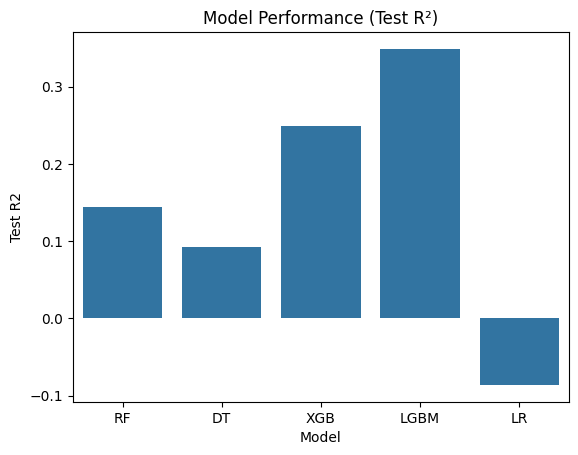

In [61]:
# Evaluate and compare all models
import time

results = []
for model_name, grid in [('RF', grid_rf), ('DT', grid_dt), ('XGB', grid_xgb), ('LGBM', grid_lgb), ('LR', grid_lr)]:
    start_test = time.time()
    y_pred = grid.predict(X_test)
    end_test = time.time()
    test_time = end_test - start_test
    rmse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    best_score = grid.best_score_
    results.append({
        'Model': model_name,
        'Best CV Score': best_score,
        'Test RMSE': rmse,
        'Test MAE': mae,
        'Test R2': r2,
        'Test Time': test_time
    })

results_df = pd.DataFrame(results)
display(results_df)

# Print detailed results for each model
for res in results:
    print(f"Model: {res['Model']}")
    print(f"  Best CV Score: {res['Best CV Score']:.4f}")
    print(f"  Test RMSE: {res['Test RMSE']:.4f}")
    print(f"  Test MAE: {res['Test MAE']:.4f}")
    print(f"  Test R2: {res['Test R2']:.4f}")
    print(f"  Test Time: {res['Test Time']:.4f}")
    print("-" * 50)

# In[20]:
# Visualize model performance based on Test R² scores
sns.barplot(data=results_df, x='Model', y='Test R2')
plt.title('Model Performance (Test R²)')
plt.show()

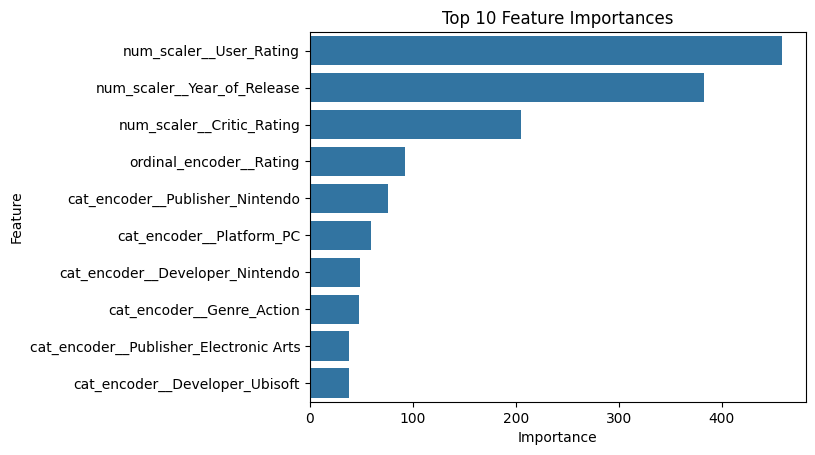

In [34]:
# Feature importance from the best model (assuming RandomForest performed best)
best_model = grid_lgb.best_estimator_
importances = best_model.named_steps['model'].feature_importances_
features = best_model.named_steps['preprocessor'].get_feature_names_out()
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances}).sort_values('Importance', ascending=False).head(10)

sns.barplot(y='Feature', x='Importance', data=importance_df)
plt.title('Top 10 Feature Importances')
plt.show()